###### Project : Menter Môn - PAM Analysis
###### Author: Vahid Seydi
###### Contact: v.seydi@bangor.ac.uk
###### Date: 2023-12-20
###### Version: 1.0
###### Description: 
The code aims to demonstrate the application of a trained RNN model for identifying marine species based on acoustic signals. It provides visualizations of the raw waveforms, evaluates the model's performance, and presents the results using a confusion matrix with image labels.

In [1]:
# Importing necessary libraries
import sys
import pandas as pd
import pickle
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
#from matplotlib.offsetbox import OffsetImage, AnnotationBbox

C:\Users\vhs20ltg\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
# Adding the path to the custom modules
sys.path.append("./Model")
from PAM_Classifiers import RNNClassifier
from PAM_Utils import *

## Loading and Preprocessing Data

We start by loading the test data and examining its structure.

In [4]:
# Loading test data
filename = './Data/test_data.pkl'
data = pd.read_pickle(filename)
data.head()

,class,wave
0,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [5]:
# Class Labels Mapping
labels = {0: 'Risso_dolphin', 1: 'Broadband_species'}

## Visualizing Sample Waveforms

Ploting sample waveforms for both Risso Dolphin and Broadband Species to provide a visual understanding of the data.


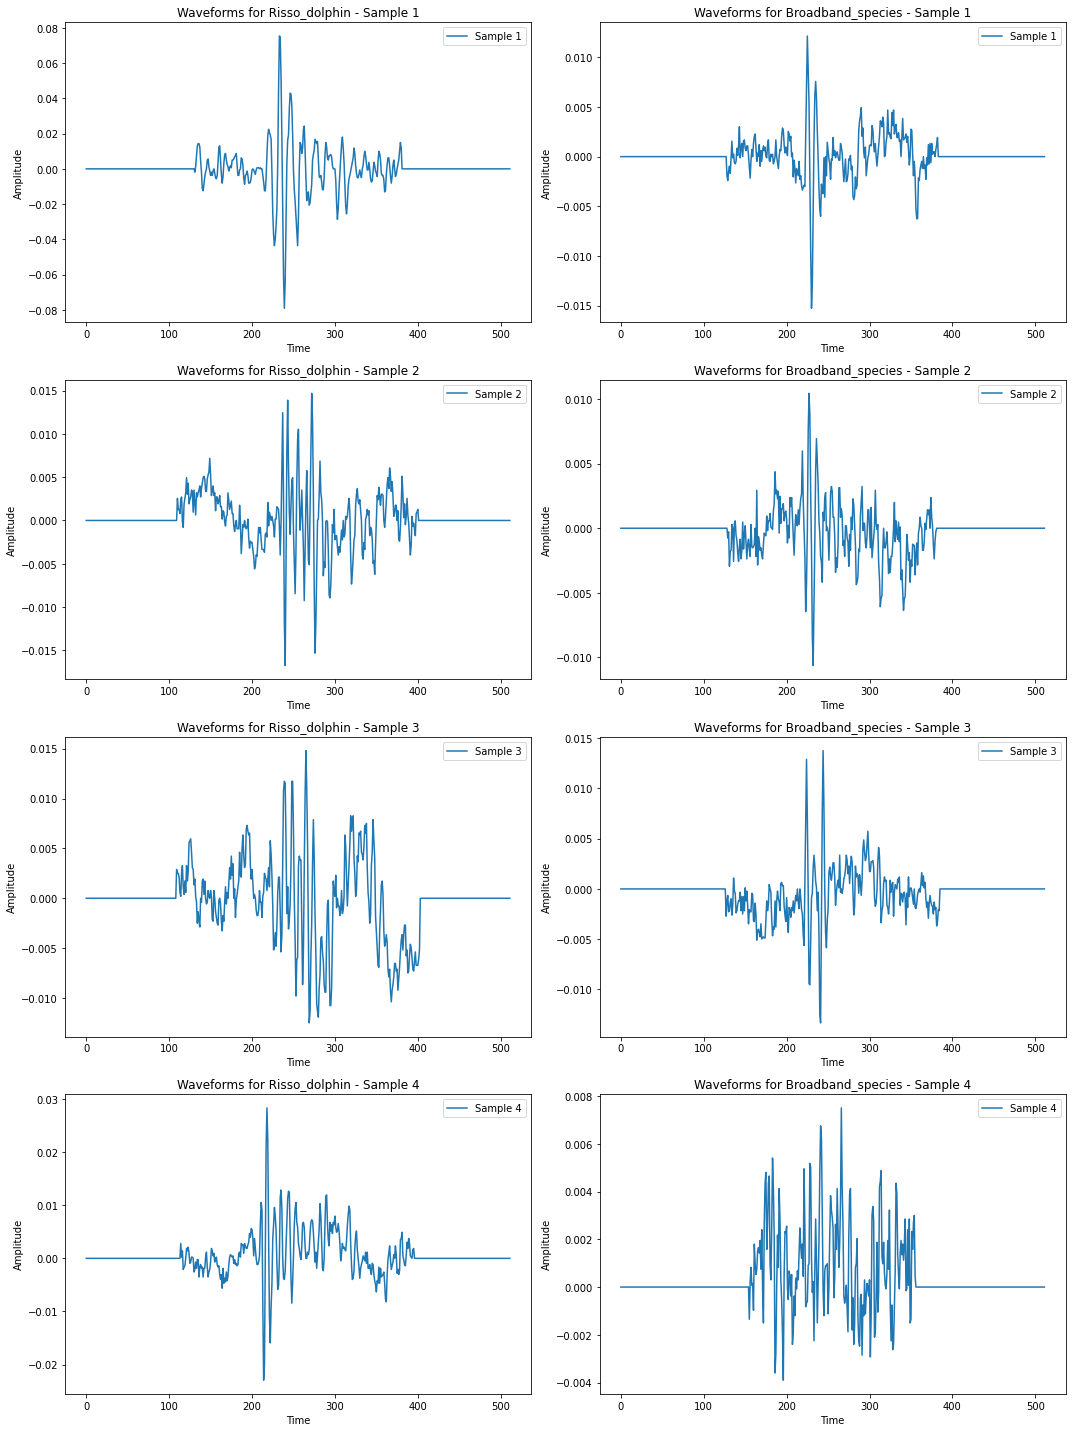

In [6]:
# Filter waves based on class for visualization
risso_dolphin_waves = data[data['class'] == 0]['wave'].tolist()[:4]
broadband_species_waves = data[data['class'] == 1]['wave'].tolist()[:4]

# ### Plotting Waves for Visualization
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Plot waves for Risso Dolphin
for i, wave in enumerate(risso_dolphin_waves):
    axs[i, 0].plot(wave, label=f'Sample {i + 1}')
    axs[i, 0].set_title(f'Waveforms for {labels[0]} - Sample {i + 1}')
    axs[i, 0].set_xlabel('Time')
    axs[i, 0].set_ylabel('Amplitude')
    axs[i, 0].legend()

# Plot waves for Broadband Species
for i, wave in enumerate(broadband_species_waves):
    axs[i, 1].plot(wave, label=f'Sample {i + 1}')
    axs[i, 1].set_title(f'Waveforms for {labels[1]} - Sample {i + 1}')
    axs[i, 1].set_xlabel('Time')
    axs[i, 1].set_ylabel('Amplitude')
    axs[i, 1].legend()

plt.tight_layout()
plt.show()



## Checking GPU Availability

Checking for the availability of a GPU and print its details if it is accessible.


In [7]:
# Checking for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    print(torch.cuda.get_device_name(0))

Let's use 1 GPUs!
GeForce RTX 2060


## Loading Trained Model

Loading the trained RNN model and its best state dictionary for evaluation.


In [9]:
model = RNNClassifier(device).to(device)

In [10]:
# Loading the trained model
saved_best_model_state_dict = torch.load('./Model/rnn_raw_best_model_state_dict.pth')
model.load_state_dict(saved_best_model_state_dict)

<All keys matched successfully>

## Preparing Data for Evaluation

Preparing the data for evaluation, including converting it into sequences and creating data loaders.


In [11]:
# Preparing data for evaluation
input_size = 4
data_ = toSequences(data, input_size)
data_loader = toDataLoader(data_, 'wave')
criterion = nn.CrossEntropyLoss().to(device, dtype=torch.float)


## Model Evaluation and Confusion Matrix

Evaluating the model on the test data and obtain the confusion matrix along with evaluation metrics.


In [12]:
#Evaluation and Confusion Matrix
model.eval()  # it-disables-dropout
with torch.no_grad():
    for f, l in data_loader:
        f = f.to(device, dtype=torch.float)
        l = l.to(device)
        outputs = model(f)
        outputs_softmax = torch.log_softmax(outputs, dim=1)
        _, predicted = torch.max(outputs_softmax, dim=1)

y_true = l.cpu().detach().numpy()
y_pred = predicted.cpu().detach().numpy()

# Obtaining the confusion matrix
cm = confusion_matrix(y_true, y_pred)



## Extracting and Displaying Metrics

We extract evaluation metrics such as accuracy, precision, recall, and F1 score, and display them.


class_labels = {
    0: '![Risso Dolphin](./img/rissos.png)',
    1: '![Broadband Species](./img/bottlenose.png)'
}

In [13]:
# ### Class Labels Mapping for Images


# Extracting evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

# Displaying evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")



Accuracy: 0.9764
Precision: 0.9375
Recall: 0.9713
F1 Score: 0.9541


## Plotting Confusion Matrix with Images


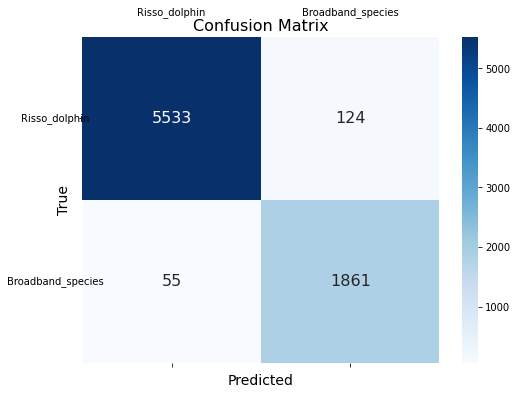

In [14]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16}, xticklabels=['', ''], yticklabels=['', ''])

# Replace x-axis labels (predicted classes) with images
for i, label in enumerate([0,1]):
    plt.text(i + 0.5, -0.15, f"{labels[i]}", ha='center', va='center', fontdict={'size': 10})
    plt.text(-0.15, i + 0.5, f"{labels[i]}", ha='center', va='center', fontdict={'size': 10})

plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

plt.show()